#**Relatório Final de Análise de Churn**

##Introdução

O objetivo desta análise é investigar os fatores associados à evasão de clientes (**churn**) em uma empresa de telecomunicações, com foco em identificar padrões que influenciam a decisão de cancelamento dos serviços. O churn é um desafio crítico, pois reter clientes existentes é mais econômico do que adquirir novos. Esta análise exploratória examina variáveis categóricas *(ex.: Contract, PaymentMethod)* e numéricas *(ex.: tenure, Charges.Total, Charges.Monthly)* para entender quais características estão correlacionadas com o churn, fornecendo insights para estratégias de retenção.

Os dados foram obtidos de um arquivo JSON hospedado em **https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json**.  O dataset contém informações sobre clientes, incluindo:

*   **customerID:** Identificador único;
*   **Churn:** Indica se o cliente cancelou (Yes) ou (No);
*   **Contract**: Tipo de contrato (ex.: Month to month, One year, Two year);
*   **PaymentMethod:** Método de pagamento (ex.: Electronic check, Credit card);
*   **tenure:** Tempo de contrato em meses;
*   **Charges.Total**: Total gasto pelo cliente;
*   **Charges.Monthly:** Gastos mensais do cliente.


A análise foi realizada com Python, utilizando as bibliotecas **Pandas, Seaborn, Matplotlib e Plotly** para manipulação de dados e visualizações.

\
#**Limpeza e Tratamento de Dados**

Os dados foram processados para garantir consistência e adequação à análise. As etapas realizadas foram:

**1. Importação dos Dados:**

* Os dados foram extraídos via API usando **requests.get** da URL fornecida e carregados em um DataFrame com **pd.read_json.**



```
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
import io
import numpy as np

url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)
dados = pd.read_json(io.StringIO(response.text))
df = pd.DataFrame(dados)
```

**2. Desaninhamento de Dicionários:**

* As colunas aninhadas *(customer, phone, internet, account)* foram desaninhadas usando **pd.json_normalize** e concatenadas ao DataFrame original, mantendo *customerID* e *Churn*.

```
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])
df = pd.concat([df[['customerID', 'Churn']], df_customer, df_phone, df_internet, df_account], axis=1)
```

**3. Padronização de Texto:**

* Hífens foram removidos das colunas *Contract* e *customerID* para consistência.

```
df['Contract'] = df['Contract'].str.replace('-', ' ')
df['customerID'] = df['customerID'].str.replace('-', ' ')
```

**4. Conversão de Tipos:**

* A coluna *Charges.Total* foi convertida de string para float, tratando valores inválidos com **errors='coerce'**.

```
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')
```

**5. Tratamento de Valores Ausentes e NaN:**

* Verificados 11 valores nulos em *Charges.Total*, que foram **substituídos por 0**, assumindo que representam clientes sem gastos **(ex.: novos contratos)**;
* Valores vazios em *Churn* foram **convertidos para NaN**, e as linhas correspondentes foram removidas.

```
df['Charges.Total'] = df['Charges.Total'].replace(np.nan, 0)
df['Churn'] = df['Churn'].replace('', np.nan)
df = df.dropna(subset=['Churn'])
```

**6. Mapeamento de Valores:**

* A coluna *SeniorCitizen* foi **transformada de 0/1 para "No"/"Yes"** (ou "não"/"sim", dependendo do mapeamento).

```
if 'SeniorCitizen' in df.columns:
    df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'sim', 0: 'não', 1: 'Yes', 0: 'No'})
```

**7. Verificação Final:**

* Após o tratamento, o DataFrame foi inspecionado com **df.info() e df.head(10)** para confirmar a ausência de problemas.

**O DataFrame tratado contém 7043 registros e 21  colunas, pronto para análise exploratória.**  

\
#**Análise Exploratória**

A análise exploratória examinou variáveis categóricas e numéricas para identificar padrões relacionados ao churn. Foram gerados gráficos para visualizar relações entre variáveis e churn.

##**1. Análise de Variáveis Categóricas:**

\
**1.1 Proporção de Churn**

Um gráfico de pizza exibiu a proporção geral de churn:

```
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title('Proporção de Churn')
plt.show()
```

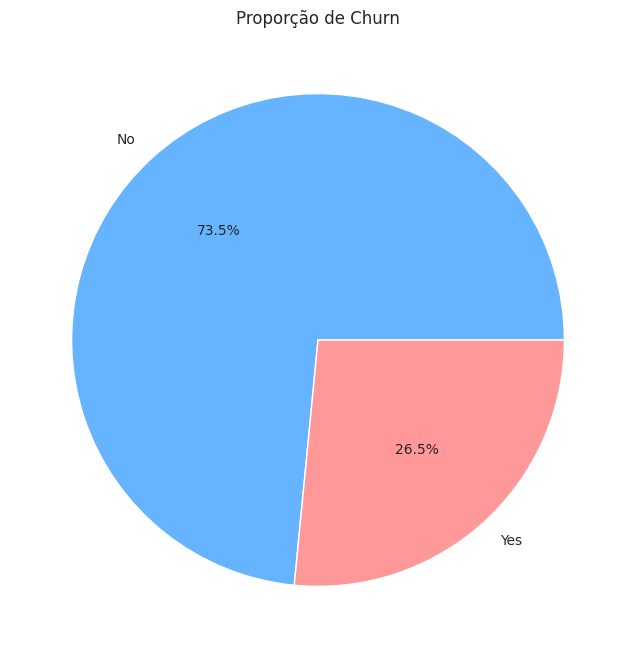



**Observação:** Aproximadamente **26.5% dos clientes churnaram**, indicando uma taxa significativa que exige atenção.

\
**1.2 Churn por Tipo de Contrato**

Um gráfico de barras mostrou a contagem de clientes por tipo de contrato, segmentada por churn:

```
sns.set_style("white")
plt.rcParams['figure.figsize'] = (10, 6)

plt.figure()
ax = sns.countplot(data=df, x='Contract', hue='Churn')
ax.bar_label(ax.containers[0], fmt='%.0f')
ax.bar_label(ax.containers[1], fmt='%.0f')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Churn por Tipo de Contrato', pad=20)
plt.xlabel('Tipo de Contrato', labelpad=15)
plt.ylabel('Quantidade de Clientes', labelpad=15)
plt.legend(title='Churn')
plt.show()
```
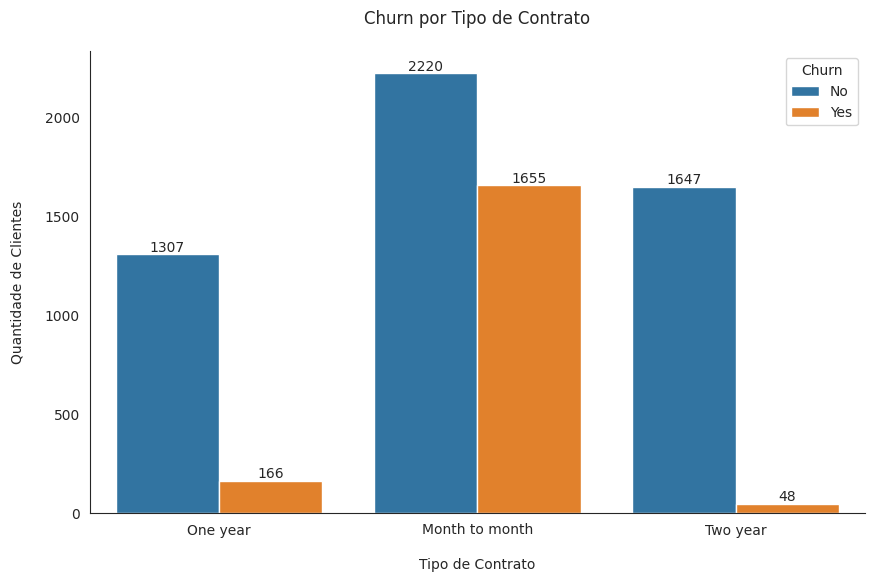

**Observação:** Contratos **"Month to month" tem maior churn (42% dos clientes churnaram)** em comparação com **"One year" (11%) e "Two year" (3%)**, sugerindo que **contratos de curto prazo estão mais associados à evasão.**

\
**1.3 Churn por Método de Pegamento**

Outro gráfico de barras analisou a contagem de churn por método de pagamento.
```
plt.figure()
ax = sns.countplot(data=df, x='PaymentMethod', hue='Churn')
ax.bar_label(ax.containers[0], fmt='%.0f')
ax.bar_label(ax.containers[1], fmt='%.0f')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Contagem de Churn por Método de Pagamento', pad=20)
plt.xlabel('Método de Pagamento', labelpad=15)
plt.ylabel('Contagem de Clientes', labelpad=15)
plt.legend(title='Churn')
plt.tight_layout()
plt.show()
```
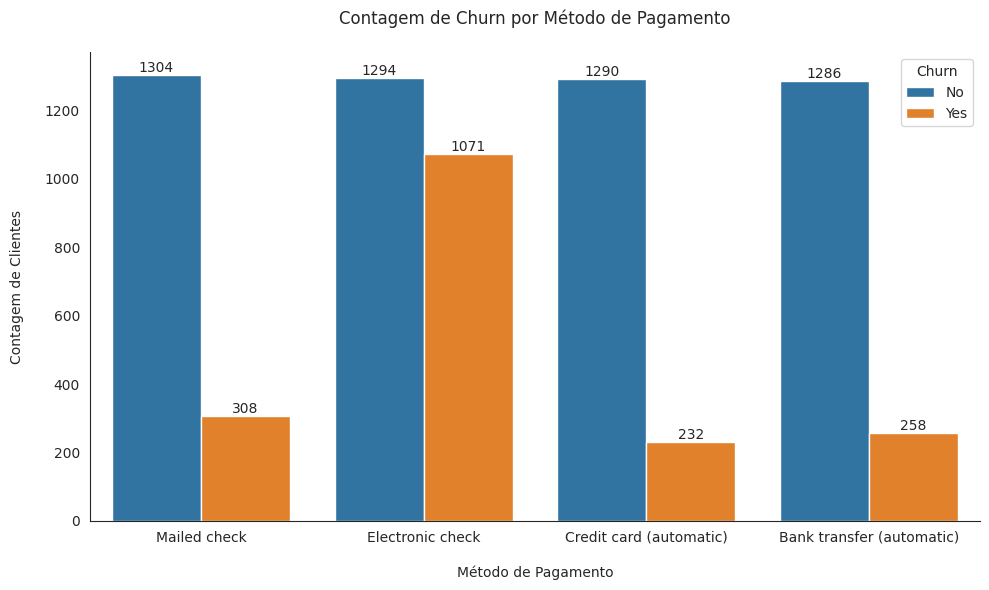

**Observação:** O método **"Electronic check" apresenta a maior taxa de churn (45% dos usuários churnaram)**, enquanto métodos automáticos (ex.: "Credit card (automatic)") tem taxas menores (15-20%).

\
##**2. Análise de Variáveis Numéricas:**

\
**2.1 Distribuição de Tenure por Churn**

Um histograma mostrou a distribuição de tenure por churn.
```
plt.figure()
ax = sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30)
plt.title('Distribuição de Tenure por Churn', pad=20)
plt.xlabel('Meses de Contrato (Tenure)', labelpad=15)
plt.ylabel('Contagem', labelpad=15)
plt.show()
```
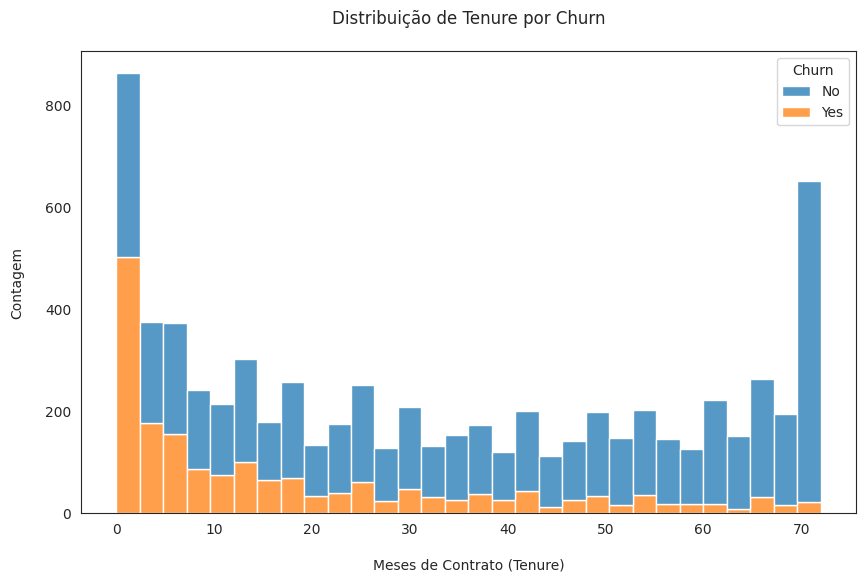

**Observação:** Clientes com **baixo tenure (menor que 12 meses) tem maior propensão ao churn**, enquanto clientes com **maior permanência (mais que 50 meses) são mais propensos a permanecer.**

\
**2.2 Distribuição de Charges.Monthly por Churn**

Um box plot analisou os gastos mensais por churn.
```
plt.figure()
sns.boxplot(data=df, x='Churn', y='Charges.Monthly')
plt.title('Distribuição de Gastos Mensais por Churn', pad=20)
plt.xlabel('Churn', labelpad=15)
plt.ylabel('Gastos Mensais (Charges.Monthly)', labelpad=15)
plt.show()
```
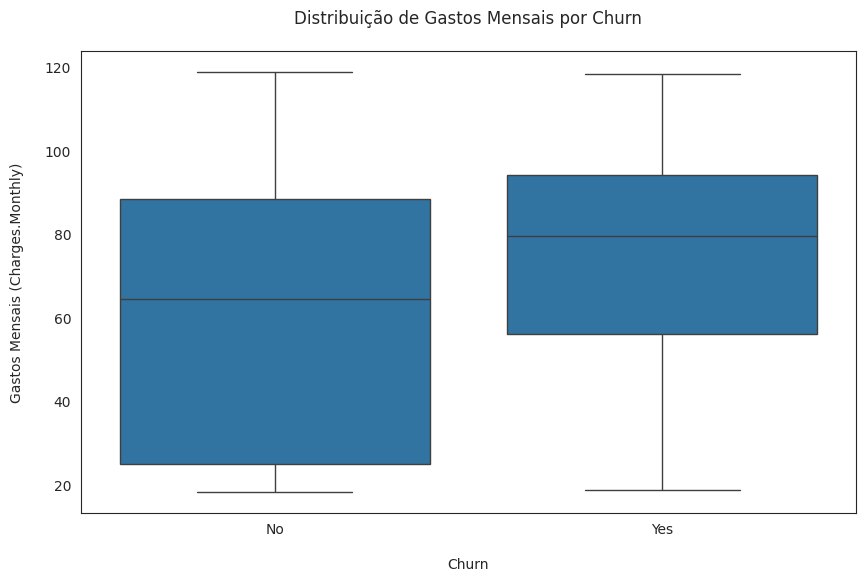

**Observação:** Clientes que churnaram têm gastos mensais mais altos (mediana ~80), sugerindo que **custos elevados podem contribuir para a evasão.**

\

**2.3 Distribuição de Charges.Total e Tenure por Churn**

Box plots, histogramas e gráficos de densidade analisaram Charges.Total e tenure.
```
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Churn', y='Charges.Total', hue='Churn', palette=['#ff9999', '#66b3ff'], legend=False)
plt.title('Distribuição de Total Gasto por Churn', pad=20)
plt.xlabel('Churn', labelpad=20)
plt.ylabel('Total Gasto (Charges.Total)', labelpad=20)

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Churn', y='tenure', hue='Churn', palette=['#ff9999', '#66b3ff'], legend=False)
plt.title('Distribuição de Tempo de Contrato por Churn')
plt.xlabel('Churn')
plt.ylabel('Tempo de Contrato')

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Charges.Total', hue='Churn', multiple='stack', bins=30, palette=['#ff9999', '#66b3ff'])
plt.title('Distribuição de Total Gasto por Churn')
plt.xlabel('Total Gasto (Charges.Total)')
plt.ylabel('Contagem')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30, palette=['#ff9999', '#66b3ff'])
plt.title('Distribuição de Tempo de Contrato por Churn')
plt.xlabel('Meses de Contrato (tenure)')
plt.ylabel('Contagem')

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(data=df, x='Charges.Total', hue='Churn', fill=True, palette=['#ff9999', '#66b3ff'])
plt.title('Densidade de Total Gasto por Churn')
plt.xlabel('Total Gasto (Charges.Total)')
plt.ylabel('Densidade')

plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, palette=['#ff9999', '#66b3ff'])
plt.title('Densidade de Tempo de Contrato por Churn')
plt.xlabel('Meses de Contrato (tenure)')
plt.ylabel('Densidade')

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()
```
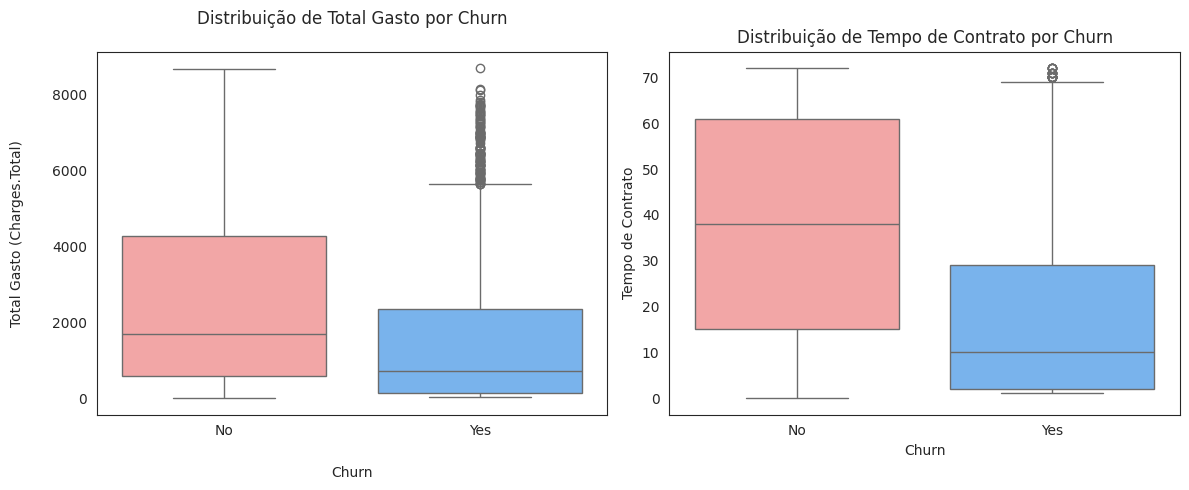
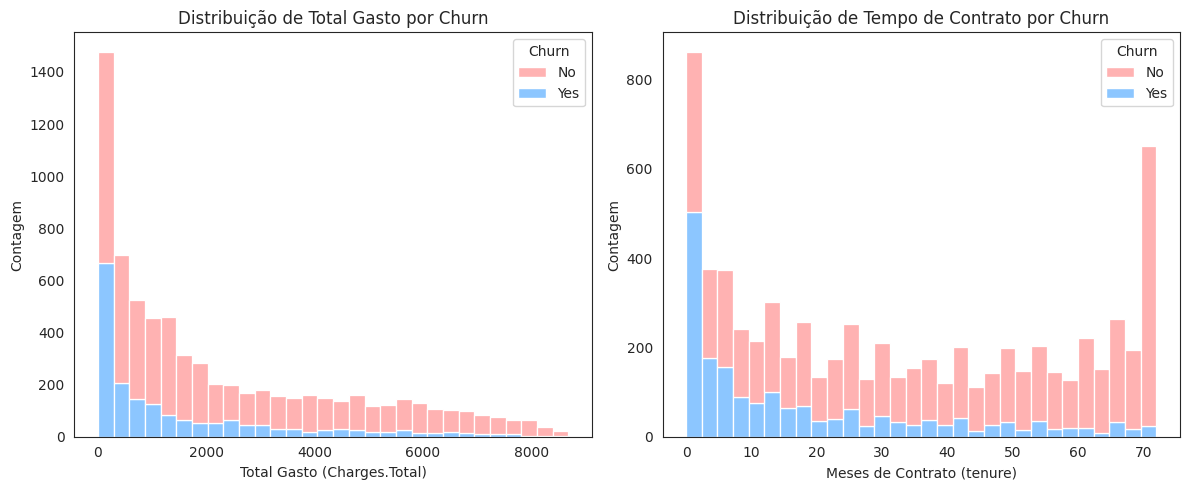
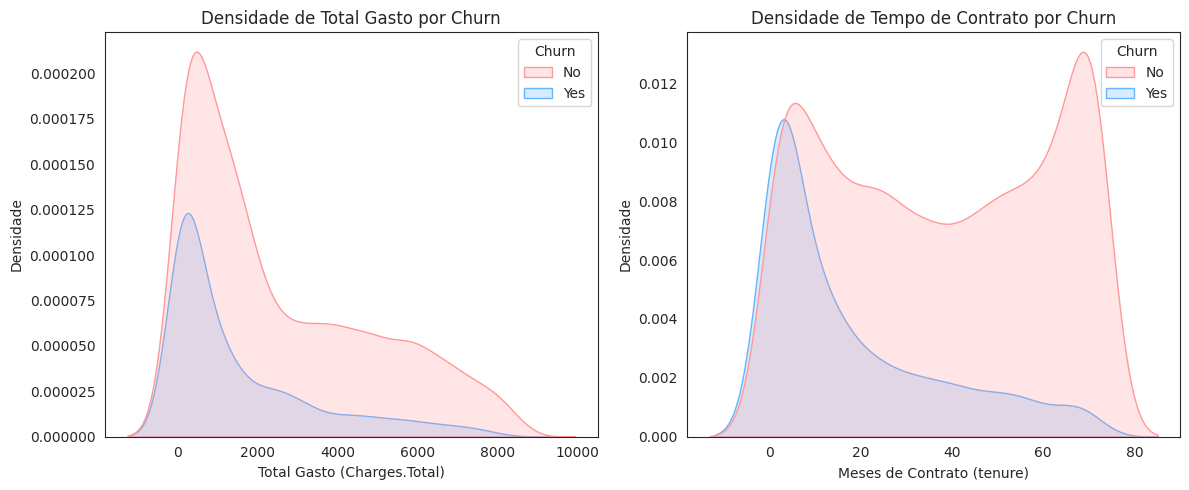

**Observação:** Clientes com **baixo Charges.Total (devido a baixo tenure) churnam mais**, enquanto clientes com **maior tenure e Charges.Total mais alto tendem a permanecer.**


\
##**Conclusão:**

\
A análise revelou padrões claros associados ao churn:

**1. Tipo de Contrato:**

* **Contratos "Month to month" tem a maior taxa de churn (42%)**, indicando que a falta de compromisso de longo prazo aumenta a probabilidade de evasão;

**2. Método de Pagamento:**

* **O método "Electronic check" está associado a uma taxa de churn de 45%**, sugerindo problemas de usabilidade ou insatisfação com esse método;

**3. Tempo de Contrato (tenure):**

* **Clientes com menos de 12 meses de contrato têm alta probabilidade de churn**, provavelmente devido a falhas no onboarding ou baixa fidelidade inicial;

**4. Gastos Mensais (Charges.Monthly):**

* **Clientes com gastos mensais mais altos (mediana ~80) são mais propensos a churnar**, indicando que custos elevados são um fator de insatisfação;

**5. Total Gasto (Charges.Total):**

* **Baixos valores de Charges.Total, associados a baixo tenure, estão correlacionados com churn**, enquanto clientes com gastos acumulados mais altos tendem a permanecer.

\
##**Insights:**

*   Clientes novos e com contratos de curto prazo são o grupo de maior risco para churn;

*   Métodos de pagamento menos automáticos, como "Electronic check", podem gerar fricções que contribuem para a evasão;

*   Custos mensais altos são um fator significativo de churn, sugerindo que a percepção de valor pode ser baixa para esses clientes.


\
##**Recomendações:**

Com base nos insights, as seguintes ações são recomendadas para reduzir o churn:

**1. Incentivar Contratos de Longo Prazo:**

Oferecer descontos ou benefícios (ex.: meses grátis) para clientes que optarem por contratos de um ou dois anos, reduzindo a taxa de churn associada a contratos "Month to month";

**2. Melhorar a Experiência com Pagamentos:**

Simplificar o processo de pagamento para "Electronic check" ou incentivar métodos automáticos (ex.: cartão de crédito, transferência bancária) com benefícios como cashback;

**3. Focar no Onboarding:**

Implementar programas de suporte proativo (ex.: tutoriais, suporte dedicado) para clientes com menos de 12 meses, aumentando o engajamento inicial;

**4. Revisar Estratégias de Preços:**

Avaliar a estrutura de preços para reduzir Charges.Monthly de clientes com altos gastos, oferecendo planos alternativos ou pacotes com maior percepção de valor;

**5. Segmentação e Personalização:**

Usar os insights para segmentar clientes de alto risco (ex.: baixo tenure, alto Charges.Monthly, "Electronic check") e direcionar campanhas personalizadas, como ofertas de retenção;

**6. Monitoramento Contínuo:**

Criar um painel de monitoramento com métricas de churn por Contract, PaymentMethod, tenure e Charges.Monthly para avaliar o impacto das ações implementadas.

\
___

**Esta análise exploratória identificou fatores críticos que influenciam o churn, como tipo de contrato, método de pagamento, tempo de contrato e gastos mensais. As visualizações geradas (barras, pizza, histogramas, box plots, dispersão, densidade) forneceram uma base sólida para entender o comportamento dos clientes.**










